In [1]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from PIL import Image
import seaborn as sns
import numpy as np
import albumentations as A
import random

import paddle
import paddle.nn as nn
import paddle.nn.functional as F

from models.unet import UNet
from utils.vis import rgb2label, label2rgb, six_class_color_map, get_vis_samples
from utils.data import MosaicAugmentation, ClustedPatchMixAugmentation

## CPM-Mosaic: Clustered-Patch-Mixed Mosaic Augmentation for Aerial Image Segmentation

In [ ]:
i, j = 3, 4
img = np.array(Image.open(f"./dataset/Potsdam/images/top_potsdam_4_12_{i+1}_{j+1}_RGB.tif"))
mask = np.array(Image.open(f"./dataset/Potsdam/labels/top_potsdam_4_12_{i+1}_{j+1}_label.tif"))

i, j = 1, 2
img2 = np.array(Image.open(f"./dataset/Potsdam/images/top_potsdam_4_12_{i+1}_{j+1}_RGB.tif"))
mask2 = np.array(Image.open(f"./dataset/Potsdam/labels/top_potsdam_4_12_{i+1}_{j+1}_label.tif"))

In [ ]:
plt.imshow(img)

In [ ]:
plt.imshow(mask)

In [ ]:
mosaic_transform = MosaicAugmentation((256, 256))
cpm_transform = ClustedPatchMixAugmentation((512, 512), (256, 256), include_classes=[3, 4, 5])

In [ ]:
sampled_idx = [1, 4, 2, 5]
sampled_idy = [3, 2, 4, 5]

sub_imgs, sub_masks = [], []
for i, j in zip(sampled_idx, sampled_idy):
    img = np.array(Image.open(f"./dataset/Potsdam/images2/top_potsdam_4_12_{i+1}_{j+1}_RGB.tif"))
    mask = np.array(Image.open(f"./dataset/Potsdam/labels2/top_potsdam_4_12_{i+1}_{j+1}_label.tif"))
    sub_imgs.append(img)
    sub_masks.append(mask)
    Image.fromarray(img).save(f"./doc/images/top_potsdam_4_12_{i+1}_{j+1}_RGB.jpg")
    Image.fromarray(
        np.uint8(label2rgb(mask, six_class_color_map(), (512, 512)))).save(
            f"./doc/images/top_potsdam_4_12_{i+1}_{j+1}_label.jpg"
        )

In [ ]:
sub_imgs2, sub_masks2 = [], []
for img, mask, i, j in zip(sub_imgs, sub_masks, sampled_idx, sampled_idy):
    _img, _mask = mosaic_transform._crop_sub_img(img, mask)
    Image.fromarray(_img).save(f"./doc/images/top_potsdam_4_12_{i+1}_{j+1}_RGB_c.jpg")
    Image.fromarray(
        np.uint8(label2rgb(_mask, six_class_color_map(), (256, 256)))).save(
            f"./doc/images/top_potsdam_4_12_{i+1}_{j+1}_label_c.jpg"
        )
    sub_imgs2.append(_img)
    sub_masks2.append(_mask)

In [ ]:
img_mosaic, mask_mosaic = mosaic_transform._combine_sub_imgs_masks(sub_imgs2, sub_masks2)

In [ ]:
Image.fromarray(np.uint8(img_mosaic)).save("./doc/images/mosaic_sample_rgb.jpg")
Image.fromarray(
    np.uint8(label2rgb(mask_mosaic, six_class_color_map(), (512, 512)))).save(
        "./doc/images/mosaic_sample_label.jpg"
    )

In [ ]:
cpm_img = np.array(Image.open(f"./dataset/Potsdam/images2/top_potsdam_4_12_1_5_RGB.tif"))
cpm_mask = np.array(Image.open(f"./dataset/Potsdam/labels2/top_potsdam_4_12_1_5_label.tif"))

In [ ]:
Image.fromarray(np.uint8(cpm_img)).save("./doc/images/cpm_img.jpg")
Image.fromarray(np.uint8(label2rgb(cpm_mask, six_class_color_map(), (512, 512)))).save("./doc/images/cpm_mask.jpg")

In [ ]:
plt.imshow(cpm_mask)

In [ ]:
_cpm_transformed = cpm_transform.cpm_transforms(image=cpm_img, mask=cpm_mask)
_cpm_img, _cpm_mask = _cpm_transformed['image'], _cpm_transformed['mask']
n, cluster_mask = cpm_transform.make_cluster_mask(_cpm_mask)
print(n)

In [ ]:
Image.fromarray(np.uint8(_cpm_img)).save("./doc/images/cpm_ref_img.jpg")

In [ ]:
Image.fromarray(np.uint8(label2rgb(_cpm_mask, six_class_color_map(), (256, 256)))).save("./doc/images/cpm_ref_label.jpg")

In [ ]:
plt.imshow(cluster_mask)

In [ ]:
cpm_transform.npatch = 8
sampled_patch_mask = cpm_transform.sample_patch(cluster_mask, n)

In [ ]:
plt.imshow(sampled_patch_mask)

In [ ]:
sampled_patch_rgb = _cpm_img * sampled_patch_mask[:, :, np.newaxis]

In [ ]:
sampled_patch_label = label2rgb(_cpm_mask, six_class_color_map(), (256, 256)) * sampled_patch_mask[:, :, np.newaxis]

In [ ]:
Image.fromarray(np.uint8(sampled_patch_rgb)).save("./doc/images/sampled_patch_rgb.jpg")

In [ ]:
Image.fromarray(np.uint8(sampled_patch_label)).save("./doc/images/sampled_patch_label.jpg")

In [ ]:
rd_x = random.randint(0, 512-256-1)
rd_y =random.randint(0, 512-256-1)

_img, _label = img_mosaic.copy(), mask_mosaic.copy()

_img[rd_x:rd_x+256, rd_y:rd_y+256, :] = \
    _img[rd_x:rd_x+256, rd_y:rd_y+256, :] * (1-sampled_patch_mask[:, :, np.newaxis]) + \
        sampled_patch_mask[:, :, np.newaxis] * _cpm_img
_label[rd_x:rd_x+256, rd_y:rd_y+256] = \
    _label[rd_x:rd_x+256, rd_y:rd_y+256] * (1-sampled_patch_mask) + \
        sampled_patch_mask * _cpm_mask

In [ ]:
Image.fromarray(np.uint8(_img)).save("./doc/images/cpm_final_img.jpg")

In [ ]:
Image.fromarray(np.uint8(label2rgb(_label, six_class_color_map(), (512, 512)))).save("./doc/images/cpm_final_label.jpg")

/home/yijie/Documents/Programs/miniconda3/envs/paddle/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/yijie/Documents/Programs/miniconda3/envs/paddle/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/yijie/Documents/Programs/miniconda3/envs/paddle/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/yijie/Documents/Programs/miniconda3/envs/paddle/lib/python3.11/site-packages/seaborn/_oldcore.py

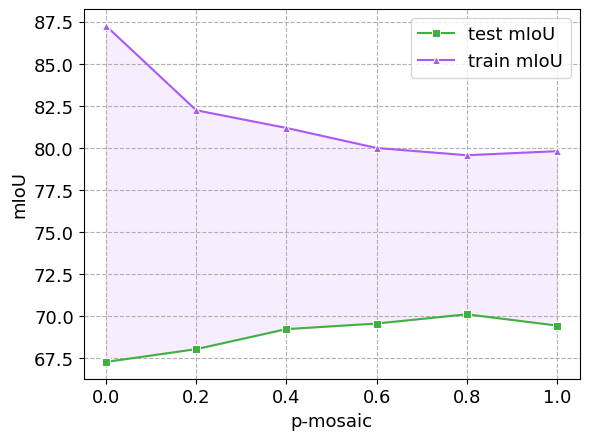

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

x = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
y1 = [67.28, 68.04, 69.23, 69.56, 70.11, 69.44]
y2 = [87.24, 82.23, 81.18, 79.99, 79.56, 79.80]

sns.lineplot(x=x, y=y1, color=(62/255, 177/255, 62/255), marker='s', label="test mIoU")
sns.lineplot(x=x, y=y2, color=(170/255, 89/255, 246/255), marker="^", label="train mIoU")

plt.fill_between(x, y1, y2, color=(170/255, 89/255, 246/255), alpha=0.1)

plt.grid(True, linestyle="--")

plt.xlabel("p-mosaic", fontsize=13)
plt.ylabel("mIoU", fontsize=13)

plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend(fontsize=13)

plt.savefig("./doc/graphs/miou_p_mosaic.pdf")
plt.show()

/home/yijie/Documents/Programs/miniconda3/envs/paddle/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/yijie/Documents/Programs/miniconda3/envs/paddle/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/yijie/Documents/Programs/miniconda3/envs/paddle/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/yijie/Documents/Programs/miniconda3/envs/paddle/lib/python3.11/site-packages/seaborn/_oldcore.py

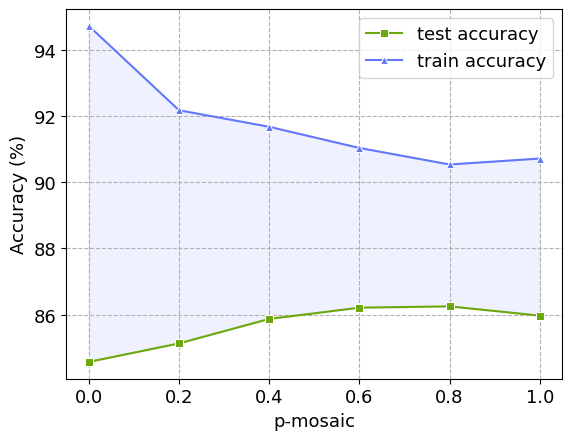

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

x = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
y1 = [84.57, 85.13, 85.87, 86.21, 86.25, 85.97]
y2 = [94.73, 92.18, 91.68, 91.04, 90.54, 90.72]

sns.lineplot(x=x, y=y1, color=(107/255, 168/255, 12/255), marker='s', label="test accuracy")
sns.lineplot(x=x, y=y2, color=(100/255, 119/255, 251/255), marker="^", label="train accuracy")

plt.fill_between(x, y1, y2, color=(100/255, 119/255, 251/255), alpha=0.1)

plt.grid(True, linestyle="--")

plt.xlabel("p-mosaic", fontsize=13)
plt.ylabel("Accuracy (%)", fontsize=13)

plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend(fontsize=13)

plt.savefig("./doc/graphs/acc_p_mosaic.pdf")
plt.show()

In [2]:
test_samples = [
    'top_potsdam_2_13', 'top_potsdam_2_14', 'top_potsdam_3_13', 'top_potsdam_3_14',
    'top_potsdam_4_13', 'top_potsdam_4_14', 'top_potsdam_4_15', 'top_potsdam_5_13',
    'top_potsdam_5_14', 'top_potsdam_5_15', 'top_potsdam_6_13', 'top_potsdam_6_14', 
    'top_potsdam_6_15', 'top_potsdam_7_13', 'top_potsdam_4_12'
]

In [3]:
ckpt_path = "./ckpts/unet_mbv2_b8_no_aug.pdparam"
model = UNet(6, False)
model.set_state_dict(paddle.load(ckpt_path))
model.eval()

W0202 07:54:06.153843 159861 gpu_resources.cc:119] Please NOTE: device: 0, GPU Compute Capability: 7.5, Driver API Version: 12.0, Runtime API Version: 11.7
W0202 07:54:06.159844 159861 gpu_resources.cc:164] device: 0, cuDNN Version: 8.4.


In [4]:


samples = [[14, 3, 4], [14, 2, 3]]
img_paths, gt_paths = [], []

for s in samples:
    img_paths.append(f"./dataset/Potsdam/images2/{test_samples[s[0]]}_{s[1]}_{s[2]}_RGB.tif")
    gt_paths.append(f"./dataset/Potsdam/labels2/{test_samples[s[0]]}_{s[1]}_{s[2]}_label.tif")
    
imgs, preds, gts = get_vis_samples(model, img_paths, gt_paths, (512, 512), six_class_color_map())

In [33]:
def make_vis_figure(img_paths, gt_paths, ckpt_paths, ckpt_names):
    models = dict()
    for ckpt_path, ckpt_name in zip(ckpt_paths, ckpt_names):
        model = UNet(6, False)
        model.set_state_dict(paddle.load(ckpt_path))
        model.eval()
        models[ckpt_name] = model
    fig, ax = plt.subplots(nrows=len(img_paths), ncols=2+len(ckpt_paths), figsize=(15, 6))
    for i, (imgp, gtp) in enumerate(zip(img_paths, gt_paths)):
        img = np.array(Image.open(imgp))
        gt = label2rgb(np.array(Image.open(gtp)), six_class_color_map(), (512, 512))
        img_arr = img.transpose((2, 0, 1))[np.newaxis, :, :, :] / 255
        img_arr = paddle.to_tensor((img_arr - 0.5) / 0.5)
        ax[i, 0].imshow(img)
        ax[i, 1].imshow(gt)
        ax[i, 0].set_xticks([])
        ax[i, 0].set_yticks([])
        ax[i, 1].set_xticks([])
        ax[i, 1].set_yticks([])
        for j, (name, model) in enumerate(models.items()):
            pred = model(img_arr.astype('float32'))
            pred = paddle.argmax(F.softmax(pred, axis=1), axis=1)[0].numpy()
            pred = label2rgb(pred, six_class_color_map(), (512, 512))
            ax[i, j+2].imshow(pred)
            ax[i, j+2].set_xticks([])
            ax[i, j+2].set_yticks([])
            
    for i in range(len(img_paths)):
        for j in range(2+len(ckpt_paths)):
            for spine in ax[i, j].spines.values():
                spine.set_visible(False)
            
    for j, name in enumerate(['Image', 'Label']+ckpt_names):
        ax[1, j].set_xlabel(name)
    plt.tight_layout()

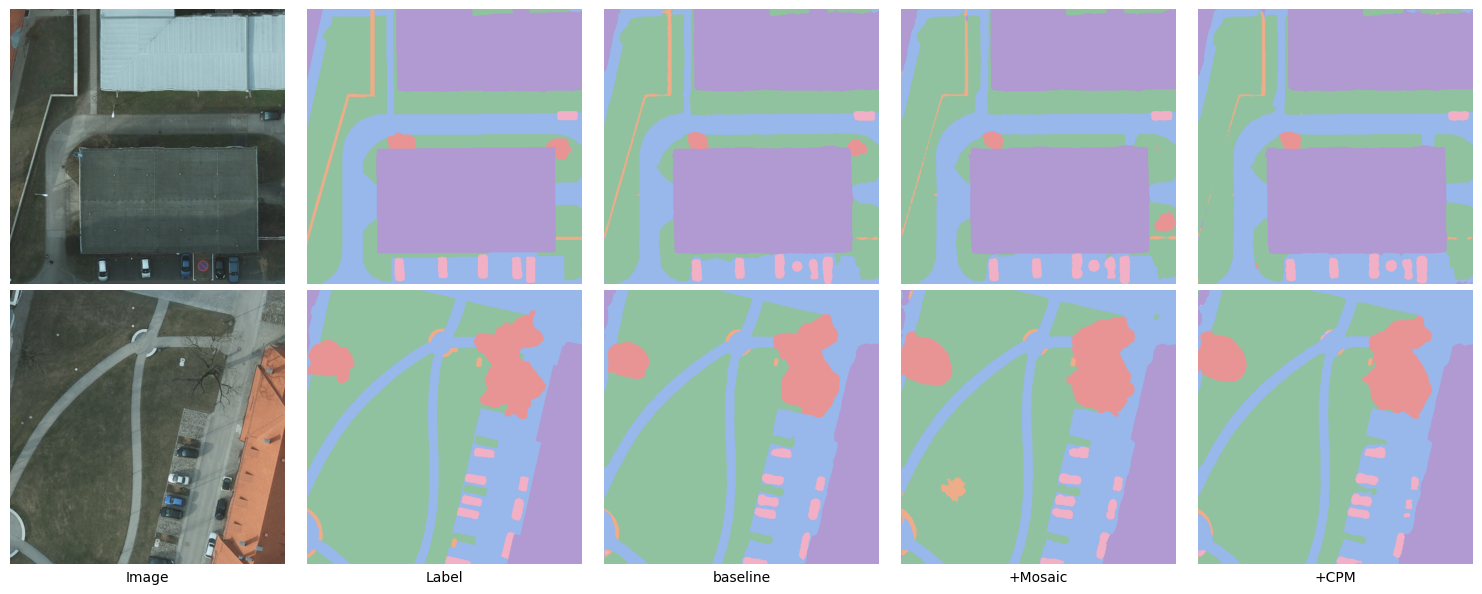

In [34]:
make_vis_figure(
    img_paths, gt_paths, 
    [
        "./ckpts/unet_mbv2_b8_no_aug.pdparam",
        "./ckpts/unet_mbv2_b8_mosaic_p08.pdparam",
        "./ckpts/unet_mbv2_b8_mosaic_p08_cpm_p08.pdparam"
    ],
    ['baseline', '+Mosaic', '+CPM']
)